In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
import sys

# ==============================================================================
# 1. CONSTANTS AND DATA SETUP (Crucial for fixing ValueError)
# ==============================================================================

IMAGE_SIZE = 256  # Must match the size expected by the model architecture
BATCH_SIZE = 32
EPOCHS = 20
DATA_DIR = 'Potato/Train'
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
NUM_CLASSES = 3  # Assuming 3 classes: Healthy, EarlyBlight, LateBlight

# --- Data Loading (Using your provided method) ---
print(f"Loading data from directory: {DATA_DIR}...")
try:
    # 1. Load Training Dataset (80% of data)
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory=DATA_DIR,
        seed=123,
        shuffle=True,
        image_size=(IMAGE_SIZE, IMAGE_SIZE), # Use 256x256
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        subset='training'
    )

    # 2. Load Validation/Test Dataset (20% of data)
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory=DATA_DIR,
        seed=123,
        shuffle=True,
        image_size=(IMAGE_SIZE, IMAGE_SIZE), # Use 256x256
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        subset='validation'
    )
    # NOTE: Since you only have train/validation split from one directory, 
    # we'll use val_ds for both validation and evaluation for simplicity here.
    test_ds = val_ds 

    class_names = train_ds.class_names
    NUM_CLASSES = len(class_names)
    print(f"Number of Classes: {NUM_CLASSES}")

except Exception as e:
    print(f"\nERROR: Data loading failed. Using mock data. ({e})")
    # --- MOCK DATA FALLBACK ---
    NUM_CLASSES = 3
    X_mock = np.random.rand(100, *INPUT_SHAPE).astype('float32')
    y_mock = np.random.randint(0, NUM_CLASSES, 100)
    
    # Create batched tf.data.Dataset objects for the structure below
    train_ds = tf.data.Dataset.from_tensor_slices((X_mock[:80] * 255.0, y_mock[:80])).batch(BATCH_SIZE)
    val_ds = tf.data.Dataset.from_tensor_slices((X_mock[80:] * 255.0, y_mock[80:])).batch(BATCH_SIZE)
    test_ds = val_ds


# --- Normalization and Performance Setup ---
def normalize_and_convert_labels(image, label):
    # Normalize images from [0, 255] to [0, 1]
    image = tf.cast(image / 255.0, tf.float32)
    return image, label

# Apply normalization and caching
train_ds = train_ds.map(normalize_and_convert_labels).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(normalize_and_convert_labels).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(normalize_and_convert_labels).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Loading data from directory: Potato/Train...
Found 900 files belonging to 3 classes.
Using 720 files for training.
Found 900 files belonging to 3 classes.
Using 180 files for validation.
Number of Classes: 3


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization, Dropout

# Assuming INPUT_SHAPE = (256, 256, 3) and NUM_CLASSES = 3 are defined globally
def build_alexnet(input_shape=(256, 256, 3), num_classes=3):
    """Builds an AlexNet-style model adapted for general input size."""
    model = models.Sequential(name="AlexNet")
    
    # 1. Block
    model.add(layers.Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())
    
    # 2. Block
    model.add(layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())
    
    # 3. Block (3 Convolutional Layers)
    model.add(layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    # Classification Head
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Instantiate the model
alexnet_model = build_alexnet(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)
print("Model definition completed: AlexNet")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model definition completed: AlexNet


In [11]:
# 1. Instantiate the model by CALLING the function
#    This line executes the code inside build_alexnet and returns the Keras model object.
alexnet_model = build_alexnet(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

# 2. Call .summary() on the Keras model object
alexnet_model.summary()

Model: "AlexNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 62, 62, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 30, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,295,043 (222.38 MB)

 Trainable params: 58,294,339 (222.38 MB)

 Non-trainable params: 704 (2.75 KB)

In [13]:
import tensorflow as tf

# --- 2.1. Model Compilation ---

# We use SparseCategoricalCrossentropy as the normalization step did not 
# convert labels to one-hot encoding.
alexnet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics=['accuracy']
)
print("Model compiled.")

# --- 2.2. Model Training ---
print(f"\nStarting AlexNet training for {EPOCHS} epochs...")

history_alexnet = alexnet_model.fit(
    train_ds,
    validation_data=val_ds, # Using val_ds for validation
    verbose=1,
    epochs=EPOCHS,
)

# --- 2.3. Model Evaluation ---
print("\nEvaluating AlexNet on the test dataset...")
scores_alexnet = alexnet_model.evaluate(test_ds, verbose=0)

# Print the final results
print("\n==============================================")
print("         AlexNet FINAL TEST RESULTS")
print("==============================================")
print(f"AlexNet Test Loss: {scores_alexnet[0]:.4f}")
print(f"AlexNet Test Accuracy: {scores_alexnet[1] * 100:.2f}%")

# Save the history object for later plotting (optional, but recommended)
# history_dict["AlexNet"] = history_alexnet

Model compiled.

Starting AlexNet training for 20 epochs...
Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.3971 - loss: 5.5508 - val_accuracy: 0.2667 - val_loss: 1.1088
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4856 - loss: 1.0672 - val_accuracy: 0.4000 - val_loss: 1.1166
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.3416 - loss: 1.1098 - val_accuracy: 0.2667 - val_loss: 1.1029
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.3470 - loss: 1.0971 - val_accuracy: 0.2722 - val_loss: 1.1046
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5364 - loss: 0.9399 - val_accuracy: 0.2778 - val_loss: 1.1790
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5328 - loss: 0.9104 - val_accuracy: 0.5000 - val_loss: 1.0853
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5222 - loss: 0.9075 - val_accuracy: 0.4778 - val_loss: 0.9361
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accura

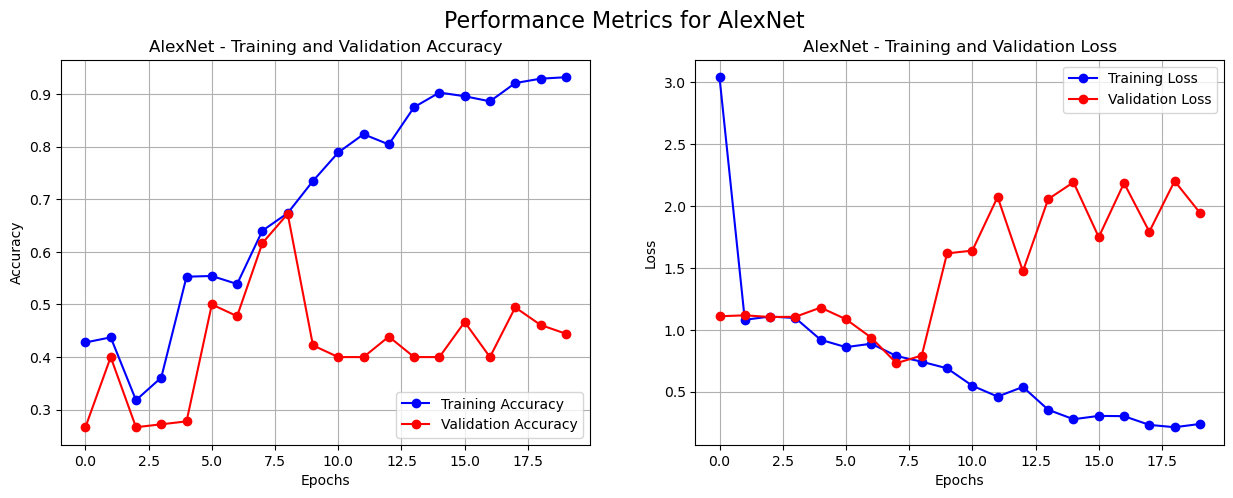

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. SETUP ---
model_name = "AlexNet"
# Directly assign the generated history object
history = history_alexnet 

# --- 2. Extract Data ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Determine EPOCHS from the length of the history list
EPOCHS = len(acc) 
epochs_range = range(EPOCHS)

# --- 3. Plotting ---
plt.figure(figsize=(15, 5))

# === Subplot 1: Accuracy ===
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
plt.title(f'{model_name} - Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# === Subplot 2: Loss ===
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title(f'{model_name} - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# --- 4. Display ---
plt.suptitle(f'Performance Metrics for {model_name}', fontsize=16)
plt.show()